このスクリプトで、Public  Score = 0.80861を獲得しました。<br>
2020/6/12現在、上位７％になっています。
ご参考にどうぞ

# 0.ライブラリ・データの読み込み

In [44]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

In [45]:
path = "./input/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# 1.データの概観・分析・前処理

## 1.1データの概観

In [46]:
tr_n,tr_d = df.shape
va_n,va_d = df_test.shape
print('n = {}, d = {} @ train data'.format(tr_n, tr_d))
print('n = {}, d = {} @ test data'.format(va_n,va_d))

n = 891, d = 12 @ train data
n = 418, d = 11 @ test data


In [47]:
#データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [48]:
#データの統計量を確認
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 1.2 データ分析 

In [49]:
temp_merge = pd.concat([df.isnull().sum(),df_test.isnull().sum()],axis=1,sort=False)
temp_merge.columns = ['Train_null','Test_null']
temp_merge

,Train_null,Test_null
PassengerId,0,0.0
Survived,0,NaN
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,177,86.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,1.0


Age,Cabinは、欠損値が多いので、今回は、補完しない。<br>
適当な補完をすれば、それが起因して予測精度が下がってしまう可能性。<br>
Embarkedは、補完する

### 1.2.1 生存割合の確認

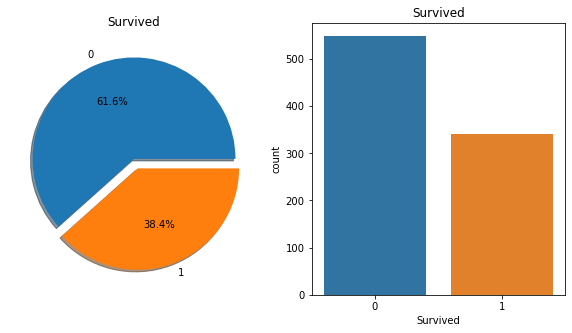

In [50]:
f,ax=plt.subplots(1,2,figsize=(10,5))
df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

死亡者の割合の方が多い61.6%

### 1.2.2 Pclass

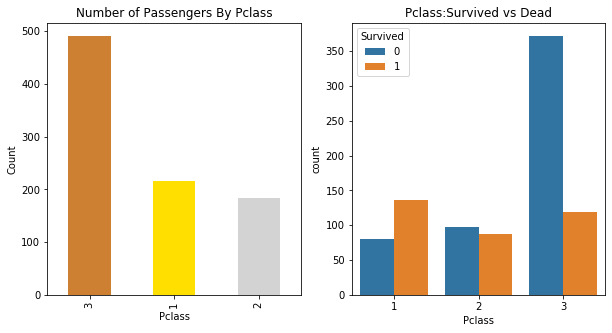

In [51]:
f,ax=plt.subplots(1,2,figsize=(10,5))
df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Pclass')

sns.countplot('Pclass',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

Pclass=3(一番グレードが低い）の生存率が非常に高いことがわかる。<br>
一方、Pclass=1では、生存率が高くなっている。<br>
これらの情報は、有効に使用できる。

### 1.2.3 Age

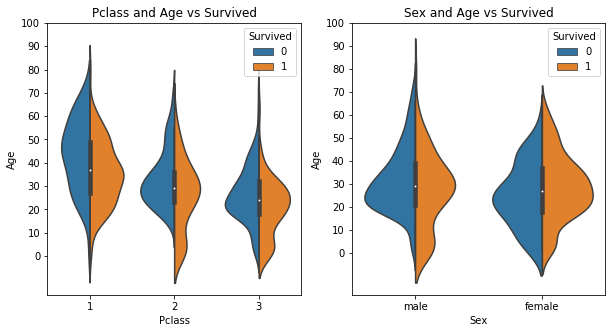

In [52]:
f,ax=plt.subplots(1,2,figsize=(10,5))
sns.violinplot("Pclass","Age", hue="Survived", data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot("Sex","Age", hue="Survived", data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

右図の男児に注目。<br>
男性かつ、10才以下では、生存率が高くなっていることがわかる。<br>
一方、男性かつ、高齢の方は、死亡率が高い。<br>
また、女性かつ高齢の方で、生存率が高いのが面白い。

### 1.2.3 SibSp

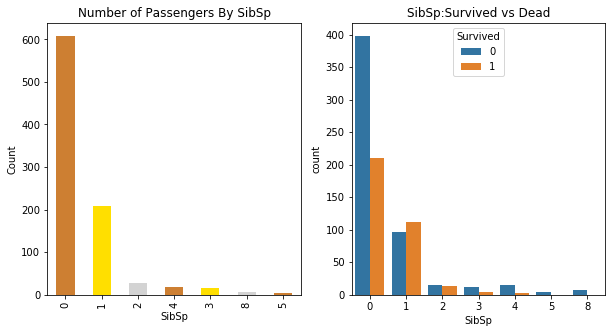

In [53]:
#乗っていた兄弟・姉妹・配偶者の数
f,ax=plt.subplots(1,2,figsize=(10,5))
df['SibSp'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By SibSp')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('SibSp')

sns.countplot('SibSp',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('SibSp:Survived vs Dead')
plt.show()

SibSpが大きいほど、生存率は小さくなっている。<br>
（SibSp=1の時に生存者の方が多くなっているのが不思議）<br>
SibSp=0の時は、生存率が小さい

### 1.2.4 Parch

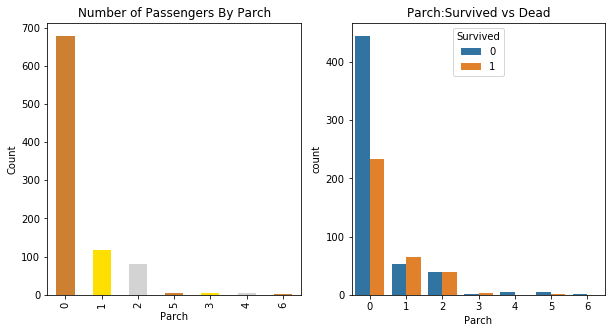

In [54]:
#乗っていた親・子供の数
f,ax=plt.subplots(1,2,figsize=(10,5))
df['Parch'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Parch')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Parch')

sns.countplot('Parch',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('Parch:Survived vs Dead')
plt.show()

Parchが大きいほど、生存率が小さくなっている。<br>
SibSpと同様に、Parch=1,2の時に生存率が多くなっているのが不思議<br>
小さい子供がいると生存率が大きくなるのか。<br>
また、Parch=0の時は、生存率が小さい

### 1.2.5 Fare

In [55]:
def fare_bin(df,nbin):
    df.loc[:, 'Fare_bin'] = pd.qcut(df.Fare, nbin,labels=False)
    #print(df.groupby('Fare_bin')['Survived'].mean())
    plt.scatter(df.groupby('Fare_bin')['Survived'].mean().index,df.groupby('Fare_bin')['Survived'].mean())
    plt.xlabel('Fare_bin')
    plt.ylabel('Survived rate')
    plt.title('Fare_bin vs Survived rate')

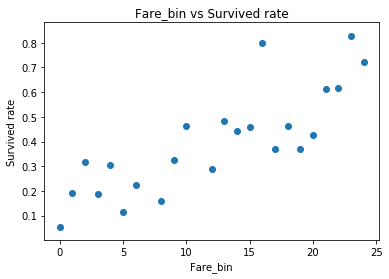

In [56]:
nbin=25
fare_bin(df,nbin)

Text(0.5, 1.0, 'Fare_bin vs Survived rate')

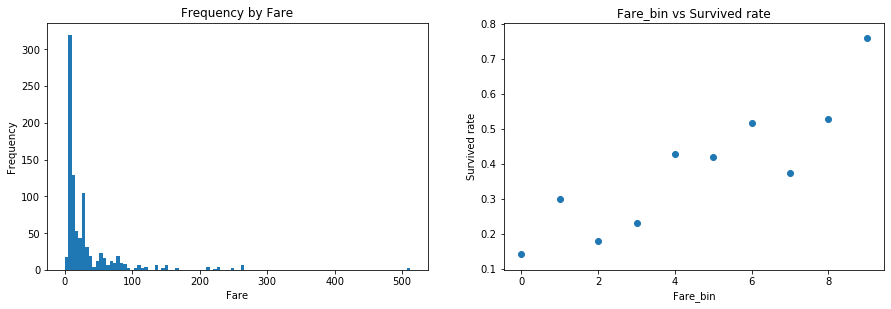

In [57]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
plt.hist(df['Fare'],bins=100)
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Frequency by Fare')

ax = fig.add_subplot(222)
df.loc[:, 'Fare_bin'] = pd.qcut(df.Fare, 10,labels=False)
plt.scatter(df.groupby('Fare_bin')['Survived'].mean().index,df.groupby('Fare_bin')['Survived'].mean())
plt.xlabel('Fare_bin')
plt.ylabel('Survived rate')
plt.title('Fare_bin vs Survived rate')

In [58]:
df.loc[:, 'Fare_bin'] = pd.qcut(df.Fare, 10,)
df.groupby('Fare_bin')['Survived'].agg(['mean','count'])

,mean,count
Fare_bin,,
"(-0.001, 7.55]",0.141304,92
"(7.55, 7.854]",0.298851,87
"(7.854, 8.05]",0.179245,106
"(8.05, 10.5]",0.230769,78
"(10.5, 14.454]",0.428571,84
"(14.454, 21.679]",0.420455,88
"(21.679, 27.0]",0.516854,89
"(27.0, 39.688]",0.373626,91
"(39.688, 77.958]",0.528090,89


In [59]:
del df['Fare_bin']

やはり、乗船料金が多い人（お金持ち）ほど生存率が高い。
正の相関は強そう。
しかし、乗車料が高い人は、それほど多くない

### 1.2.6 変数同士のヒートマップ

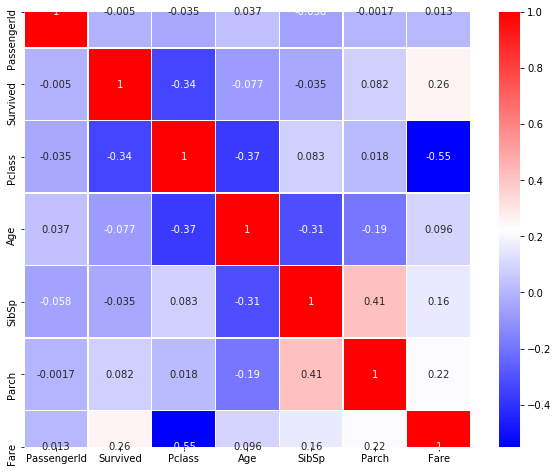

In [60]:
fig = plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

正の相関 : <br>
SibSp & Parch:<br>
Fare & Survive: お金持ちほど、生存率が高い<br><br>
負の相関 : <br>
Pclass & Fare : チケットのグレードが高ければ、料金は、高くなる。<br>
Pclass & Survived:お金持ちほど、生存率が高い<br>
Age & Survived:高齢ほど、死亡率が高い<br>
SibSp & Age:子供がいる方は、年齢が上である可能性が高い？<br>

## 1.3データの前処理

### 1.3.1 欠損値の処理
欠損値がある特徴量<br>
Age, Cabin, Fare, Embarked<br><br>
Ageは２割程度,Cabinは８割程度欠損ちが含まれている。<br>
これらを適当に補完すると、精度が落ちる可能性があるので、今回は、難しく考えず補完しない方向で行う。<br>

### 1.3.1.1 Fare 補完

In [61]:
print('All average:',pd.concat([df['Fare'], df_test['Fare']]).mean())
temp_merge = pd.concat([df[['Pclass','Fare']],df_test[['Pclass','Fare']]])
temp_merge.groupby('Pclass')['Fare'].mean()

All average: 33.29547928134557


Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

平均値とPclassごとの平均は結構違う<br>
よって、FareはPclassと相関が強いので、Pclass中の平均値をしようすることにする

In [62]:
groupby_pclass_fare = temp_merge.groupby('Pclass').mean()
df['Fare'].loc[(df['Fare'].isnull())] = groupby_pclass_fare.loc[df['Pclass'].loc[(df['Fare'].isnull())]]['Fare']
df_test['Fare'].loc[(df_test['Fare'].isnull())] = groupby_pclass_fare.loc[df_test['Pclass'].loc[(df_test['Fare'].isnull())]]['Fare'].values

### 1.3.1.2 Embarked
Sが最も多い。補完は、Sとする。

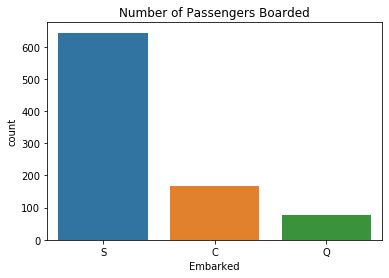

In [63]:
sns.countplot('Embarked',data=df)
plt.title('Number of Passengers Boarded')
plt.show()

In [64]:
df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

### 1.3.1.3 Cabin

In [65]:
df['IsCabin'] = df['Cabin'].isnull()
df.groupby('IsCabin')['Survived'].mean()
del df['IsCabin']

キャビンがわかる方は、かなり生存率が高いことがわかります。この指標は、使用できるかしれません。

In [66]:
df['Survived'].groupby(df['Cabin'].map(lambda x: str(x)[0])).agg(['mean','count'])

,mean,count
Cabin,,
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
T,0.000000,1
n,0.299854,687


今回は、キャビンの頭文字を使用してダミー変数を作成する

In [67]:
df_test.groupby(df_test['Cabin'].map(lambda x: str(x)[0])).agg(['count'])['PassengerId']

,count
Cabin,
A,7
B,18
C,35
D,13
E,9
F,8
G,1
n,327


In [68]:
less_than_10_list = list(df.groupby(df['Cabin'].map(lambda x: str(x)[0])).count()['PassengerId'][df.groupby(df['Cabin'].map(lambda x: str(x)[0])).count()['PassengerId']<= 15].index)
less_than_10_list
#１０以下の出現の変数は、使用しない　＞＞　Othersにまとめる

['A', 'F', 'G', 'T']

In [69]:
def make_cabin_group(df,less_than_10_list):
    l = []
    df['Cabin'].fillna('None',inplace=True)
    
    df['Cabin_Initial'] = df['Cabin'].map(lambda x: str(x)[0])
    for i in less_than_10_list:
        df['Cabin_Initial'] = df['Cabin_Initial'].replace(i,'Others',regex=True)
        
    df['Cabin_Initial'] = df['Cabin_Initial'].replace('n','None',regex=True)
    df['Cabin_Initial'] = df['Cabin_Initial'].map(lambda x:str(x))
    
    try:
        print(df['Survived'].groupby(df['Cabin_Initial'].map(lambda x: str(x)[0])).agg(['mean','count']))
    except:
        print(df.groupby('Cabin_Initial')['PassengerId'].count())
    return df

In [70]:
df = make_cabin_group(df,less_than_10_list)
df_test = make_cabin_group(df_test,less_than_10_list)

                   mean  count
Cabin_Initial                 
B              0.744681     47
C              0.593220     59
D              0.757576     33
E              0.750000     32
N              0.299854    687
O              0.515152     33
Cabin_Initial
B          18
C          35
D          13
E           9
N         327
Others     16
Name: PassengerId, dtype: int64


In [71]:
df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)
df.drop('Age', axis=1, inplace=True)
df_test.drop('Age', axis=1, inplace=True)

### 1.4 Name, Ticketをダミー変数に変化

### Name

In [72]:
#age_name = pd.concat([df[['Name','Survived']], df_test[['Name']]])
import re
def make_title(df):
    title_l = []
    mr = 'Mr.'
    mr2 = 'Mr'
    mrs = 'Mrs.'
    mrs2 = 'Mrs'
    miss = 'Miss.'
    ms = 'Ms.'
    master = 'Master.'
    doc = 'Dr.'
    rev = 'Rev.'
    col = 'Col.'
    
    for j in df['Name']:
        count = 0
        #print(j.split())
        for i in j.split():
            i = re.sub(r'\("','',i)
            if not count == 0:
                pass
            else:
                if (mr == i) or (mr2 == i):
                    title_l.append(mr)
                    count += 1
                elif (mrs == i) or (mrs2 == i):
                    title_l.append(mrs)
                    count += 1
                elif (miss == i) or (ms ==i):
                    title_l.append(miss)
                    count += 1
                elif master == i:
                    count += 1
                    title_l.append(master)
                '''
                elif doc in i:
                    count += 1
                    title_l.append(doc)
                elif rev in i:
                    count += 1
                    title_l.append(rev)
                elif col in i:
                    count += 1
                    title_l.append(col)
                '''
        if not count:
            #print(j)
            title_l.append('Othersl')
        
    print(len(title_l))
    print(df.shape)
    df['Title'] = title_l
    print(df.groupby('Title').count()['PassengerId'])
    try:
        print(df.groupby('Title').mean()['Survived'])
    except:
        pass

In [73]:
make_title(df)
print()
make_title(df_test)

891
(891, 11)
Title
Master.          40
Miss.           183
Mr.             518
Mrs.            127
Title-others     23
Name: PassengerId, dtype: int64
Title
Master.         0.575000
Miss.           0.699454
Mr.             0.158301
Mrs.            0.795276
Title-others    0.347826
Name: Survived, dtype: float64

418
(418, 10)
Title
Master.          21
Miss.            79
Mr.             240
Mrs.             72
Title-others      6
Name: PassengerId, dtype: int64


ここに、年齢・結婚の有無などの情報も含まれているはず。と予想

In [74]:
df.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)

### Ticket

Ticketの頭文字を抽出

In [75]:
df['Survived'].groupby(df['Ticket'].map(lambda x: str(x)[0])).agg(['mean','count'])

,mean,count
Ticket,,
1,0.630137,146
2,0.464481,183
3,0.239203,301
4,0.200000,10
5,0.000000,3
6,0.166667,6
7,0.111111,9
8,0.000000,2
9,1.000000,1


チケットの種類（頭文字）に関しても、ある程度生死に関わっているような印象。この頭文字の情報を利用する<br>
テストデータにない頭文字や、サンプル数が少ないチケットは、学習の阻害になったりするので、まとめてOthersにする。

In [76]:
less_than_10_list = list(df.groupby(df['Ticket'].map(lambda x: str(x)[0])).count()['PassengerId'][df.groupby(df['Ticket'].map(lambda x: str(x)[0])).count()['PassengerId']<= 10].index)
less_than_10_list

['4', '5', '6', '7', '8', '9', 'F', 'L']

In [77]:
df_test.groupby(df_test['Ticket'].map(lambda x: str(x)[0])).count()['PassengerId']

Ticket
1     64
2     95
3    128
4      1
6      3
7      4
9      1
A     13
C     30
F      6
L      1
P     33
S     33
W      6
Name: PassengerId, dtype: int64

In [78]:
def make_ticket_dummy(df,less_than_10_list):
    df['Ticket_ini'] = df['Ticket'].map(lambda x: str(x)[0])
    for i in less_than_10_list:
        df['Ticket_ini'] = df['Ticket_ini'].replace(i,'Others',regex=True)

    df['Ticket_ini'] = df['Ticket_ini'].map(lambda x:str(x))
        
    #print(df['Ticket'].value_counts(dropna=False))
    
    return df

In [79]:
df = make_ticket_dummy(df,less_than_10_list)
df_test = make_ticket_dummy(df_test,less_than_10_list)

#### 同じTicket番号をもつ人は、同乗者がいる
配偶者・兄弟・子供・親・友人など
この数が多いほど、生存確率が小さいと仮定した<br>
参考）https://yolo-kiyoshi.com/2020/01/22/post-1588/

(array([713., 132.,  49.,  16.,   7.,   4.,   5.,   2.,   0.,   1.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

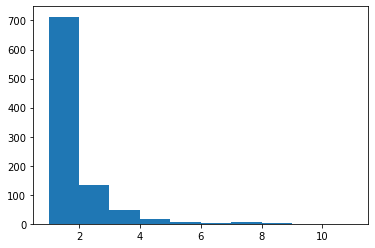

In [80]:
temp_all = pd.concat([df,df_test])
plt.hist(temp_all['Ticket'].value_counts())

In [81]:
temp_all.loc[:, 'n_same_ticket'] = temp_all.groupby(['Ticket'])['PassengerId'].transform('count')

df['n_same_ticket'] = temp_all.iloc[:tr_n, :]['n_same_ticket']
df_test['n_same_ticket'] = temp_all.iloc[tr_n:, :]['n_same_ticket']

df.groupby(['n_same_ticket'])['Survived'].agg(['mean','count'])

,mean,count
n_same_ticket,,
1,0.270270,481
2,0.513812,181
3,0.653465,101
4,0.727273,44
5,0.333333,21
6,0.210526,19
7,0.208333,24
8,0.384615,13
11,0.000000,7


なんとなく、関係があるような、ないような

### 1.5 カテゴリカルデータの数値化

### Sex
male -> 0<br>
female -> 1

In [82]:
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

### Embarked, Ticke, Name(Title),Cabin_ini をone hot vector

In [83]:
def get_onehot(df,df_test,column_name):
    temp = pd.concat([df[column_name], df_test[column_name]])
    
    temp_ohe = pd.get_dummies(temp)
    column_l = []
    for i in temp_ohe.columns:
        new_name = column_name+'_'+str(i)
        column_l.append(new_name)
    temp_ohe.columns = column_l
    
    temp_ohe_train = temp_ohe[:891].round().astype(int)
    temp_ohe_test = temp_ohe[891:].round().astype(int)
    '''
    print(df.head())
    print(df_test.head())
    print(embarked_ohe_test)
    '''
    df = pd.concat([df, temp_ohe_train], axis=1)
    df_test = pd.concat([df_test, temp_ohe_test], axis=1)
    
    df.drop(column_name, axis=1, inplace=True)
    df_test.drop(column_name, axis=1, inplace=True)
    
    df = df.dropna()
    df_test = df_test.dropna()
    
    #print(df.head())
    return df,df_test

In [84]:
column_name_l = ['Embarked','Ticket_ini','Title','Cabin_Initial']
for column_name in column_name_l:
    df,df_test = get_onehot(df,df_test,column_name)
    
    
print(df.shape)
df.head()

(891, 32)


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,n_same_ticket,Embarked_C,...,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Title-others,Cabin_Initial_B,Cabin_Initial_C,Cabin_Initial_D,Cabin_Initial_E,Cabin_Initial_N,Cabin_Initial_Others
0,1,0,3,0,1,0,A/5 21171,7.2500,1,0,...,0,1,0,0,0,0,0,0,1,0
1,2,1,1,1,1,0,PC 17599,71.2833,2,1,...,0,0,1,0,0,1,0,0,0,0
2,3,1,3,1,0,0,STON/O2. 3101282,7.9250,1,0,...,1,0,0,0,0,0,0,0,1,0
3,4,1,1,1,1,0,113803,53.1000,2,0,...,0,0,1,0,0,1,0,0,0,0
4,5,0,3,0,0,0,373450,8.0500,1,0,...,0,1,0,0,0,0,0,0,1,0


## 1.6 新しい変数の導入

### 1.6.1 Family size
みんな入れている変数

In [85]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

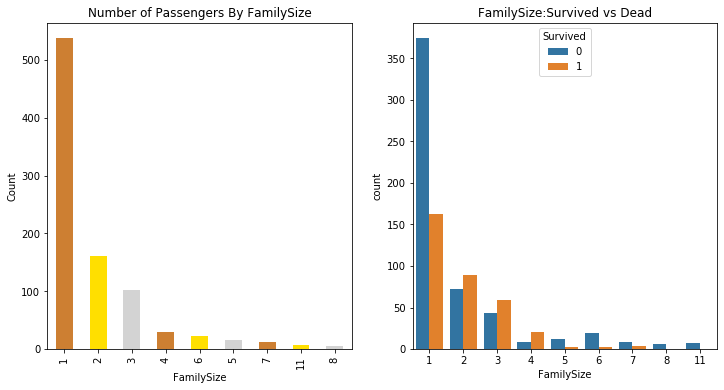

In [86]:
#乗っていた親・子供の数
f,ax=plt.subplots(1,2,figsize=(12,6))
df['FamilySize'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By FamilySize')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('FamilySize')

sns.countplot('FamilySize',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('FamilySize:Survived vs Dead')
plt.show()

Familysizeによってかなり生存率が異なるので、以下のように、分割した変数を導入する<br>
Familysize = 1 Low(alone)<br>
2 <= Familysize <= 4 High<br>
4 < Familysize <=7 Low<br>
7< Familysize Dead (Survived rate~0)<br>

Text(0.5, 1.0, 'FamilySIze vs Survived rate')

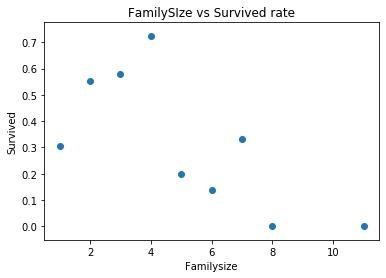

In [87]:
plt.scatter(df.groupby('FamilySize').mean()['Survived'].index,df.groupby('FamilySize').mean()['Survived'])
plt.xlabel('Familysize')
plt.ylabel('Survived')
plt.title('FamilySIze vs Survived rate')

In [88]:
def make_family(df):

    df['IsAlone'] = 0
    df['IsAlone'].loc[df['FamilySize'] == 1] = 1
    df['Family_size_small'] = 0
    df['Family_size_small'].loc[(df['FamilySize'] > 1) & (df['FamilySize'] <= 4)] = 1
    df['Family_size_mid'] = 0
    df['Family_size_mid'].loc[(df['FamilySize'] > 4) & (df['FamilySize'] <= 7)] = 1
    df['Family_size_big'] = 0
    df['Family_size_big'].loc[(df['FamilySize'] > 7) ] = 1
    del  df['SibSp'], df['Parch'], df['FamilySize']
    
    return df

In [89]:
df = make_family(df)
df_test = make_family(df_test)

## 2.モデルの構築

### 2.1 変数の整理

In [90]:
df_test = df_test.drop_duplicates()
#X = df.iloc[:, 2:].values
#y = df.iloc[:, 1].values
drop_list = [
    'PassengerId',
             'Ticket',
            ]

target = 'Survived'
X = df.drop(columns=drop_list+[target])
y = df[target]

print('n = {}, d = {}'.format(X.shape[0],X.shape[1]))
#X_test = df_test.iloc[:, 1:].values
X_test = df_test.drop(columns=drop_list)

n = 891, d = 31


In [91]:
X_test.head()

,Pclass,Sex,Fare,n_same_ticket,Embarked_C,Embarked_Q,Embarked_S,Ticket_ini_1,Ticket_ini_2,Ticket_ini_3,...,Cabin_Initial_B,Cabin_Initial_C,Cabin_Initial_D,Cabin_Initial_E,Cabin_Initial_N,Cabin_Initial_Others,IsAlone,Family_size_small,Family_size_mid,Family_size_big
0,3,0,7.8292,1,0,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,3,1,7.0000,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,2,0,9.6875,1,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
3,3,0,8.6625,1,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4,3,1,12.2875,2,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [92]:
count = 0
for i in X_test.columns:
    count += 1
    print(i,count)

Pclass 1
Sex 2
Fare 3
n_same_ticket 4
Embarked_C 5
Embarked_Q 6
Embarked_S 7
Ticket_ini_1 8
Ticket_ini_2 9
Ticket_ini_3 10
Ticket_ini_A 11
Ticket_ini_C 12
Ticket_ini_Others 13
Ticket_ini_P 14
Ticket_ini_S 15
Ticket_ini_W 16
Title_Master. 17
Title_Miss. 18
Title_Mr. 19
Title_Mrs. 20
Title_Title-others 21
Cabin_Initial_B 22
Cabin_Initial_C 23
Cabin_Initial_D 24
Cabin_Initial_E 25
Cabin_Initial_N 26
Cabin_Initial_Others 27
IsAlone 28
Family_size_small 29
Family_size_mid 30
Family_size_big 31


### 2.2 ハイパーパラメータ の調節

In [95]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.ensemble import RandomForestClassifier

parameters= {'max_depth': [5, 7,10],
              'min_samples_leaf': [1, 2, 4],
             'n_estimators':532}

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)


best_val_loss = 999
for max_depth in parameters['max_depth']:
    for min_samples_leaf in parameters['min_samples_leaf']:
        val_losses = []
        tra_losses = []
        for train_index,test_index in skf.split(X_train,y_train):
            X_tr = X_train.iloc[train_index]
            y_tr = y_train.iloc[train_index]
            X_va = X_train.iloc[test_index]
            y_va = y_train.iloc[test_index]

            scaler = StandardScaler()
            scaler.fit(X_tr)
            X_tr = scaler.transform(X_tr)
            X_va = scaler.transform(X_va)
            
            clf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                                n_estimators=parameters['n_estimators'], n_jobs=-1, random_state=42)
            clf.fit(X_tr,y_tr)
            
            pred_val_y = clf.predict_proba(X_va)
            pred_tra_y = clf.predict_proba(X_tr)
            val_loss = log_loss(y_va,pred_val_y)
            tra_loss = log_loss(y_tr,pred_tra_y)
            val_losses.append(val_loss)
            tra_losses.append(tra_loss)
        ave_tra_loss = sum(tra_losses)/len(tra_losses)
        ave_val_loss = sum(val_losses)/len(val_losses)
        if ave_val_loss < best_val_loss:
            best_val_loss = ave_val_loss
            best_tra_loss = ave_tra_loss
            best_params={
                'max_depth':max_depth,
                'min_samples_leaf':min_samples_leaf,
                'n_estimators':parameters['n_estimators']
            }
        print('max_depth: {}, min_samples_leaf:{}, train log_loss: {}, valid log_loss: {}'.format(max_depth,min_samples_leaf,round(ave_tra_loss,3),round(ave_val_loss,3)))
print('\nBest params:')
print('max_depth: {}, min_samples_leaf:{}, train log_loss: {}, valid log_loss: {}'.format(best_params['max_depth'],best_params['min_samples_leaf'],round(best_tra_loss,3),round(best_val_loss,3)))


max_depth: 5, min_samples_leaf:1, train log_loss: 0.367, valid log_loss: 0.419
max_depth: 5, min_samples_leaf:2, train log_loss: 0.375, valid log_loss: 0.422
max_depth: 5, min_samples_leaf:4, train log_loss: 0.388, valid log_loss: 0.425
max_depth: 7, min_samples_leaf:1, train log_loss: 0.3, valid log_loss: 0.408
max_depth: 7, min_samples_leaf:2, train log_loss: 0.33, valid log_loss: 0.412
max_depth: 7, min_samples_leaf:4, train log_loss: 0.362, valid log_loss: 0.419
max_depth: 10, min_samples_leaf:1, train log_loss: 0.225, valid log_loss: 0.426
max_depth: 10, min_samples_leaf:2, train log_loss: 0.297, valid log_loss: 0.416
max_depth: 10, min_samples_leaf:4, train log_loss: 0.35, valid log_loss: 0.418

Best params:
max_depth: 7, min_samples_leaf:1, train log_loss: 0.3, valid log_loss: 0.408


### 2.3 重要変数をプロット

Classification accuracy:  0.827
Test loss:  0.405


Text(0.5, 1.0, 'RandomForestClassifier feature importance')

<Figure size 1440x720 with 0 Axes>

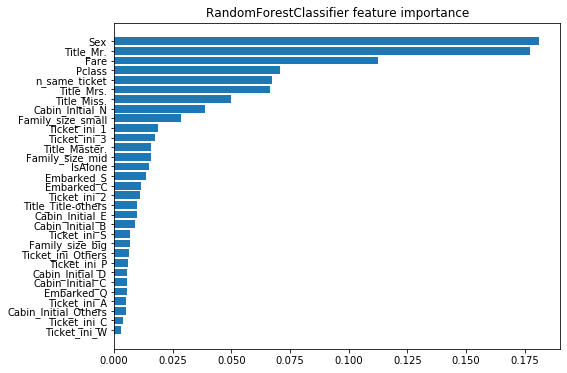

In [105]:
plt.figure(figsize=(20,10))

clf = RandomForestClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], n_estimators=best_params['n_estimators'], n_jobs=-1, random_state=42)
clf.fit(X_train,y_train)

print('Classification accuracy: ',round(clf.score(X_valid,y_valid),3))
pred_val_y = clf.predict_proba(X_valid)
val_loss = log_loss(y_valid,pred_val_y)
print('Test loss: ', round(val_loss,3))


feature_list = [int(i) for i in np.argsort(clf.feature_importances_)]

fig = plt.figure(figsize=(8.0, 6.0))
ax = fig.add_subplot(111)
plt.barh(
    X.columns[feature_list],
    clf.feature_importances_[feature_list],
    label='RandomForestClassifier'
)
plt.title('RandomForestClassifier feature importance')

### 2.4 10foldの10個の予測式を用いてEnsembleする

In [96]:
from sklearn.ensemble import RandomForestClassifier

class RF:
    def __init__(self):
        self.model = None
        self.scaler = None
    def fit(self, tr_x, tr_y, va_x, va_y):
        print('Model1RF')
        #self.scaler = StandardScaler()
        #self.scaler.fit(tr_x)
        #tr_x = self.scaler.transform(tr_x)
        self.model = RandomForestClassifier(max_depth=7, min_samples_leaf=1, n_estimators=532, n_jobs=-1, random_state=42)
        self.model.fit(tr_x,tr_y)

        #print('Train Score: {}'.format(round(self.model .score(tr_x, tr_y), 3)))
        #print(' Test Score: {}'.format(round(self.model .score(va_x, va_y), 3)))
        
    def predict(self,x):
        #x = self.scaler.transform(x)
        pred = self.model.predict_proba(x)
        return pred

In [97]:
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    #kf = KFold(n_splits=5, shuffle=True, random_state=10)
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(skf.split(train_x,train_y)):#.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test

In [98]:
RF = RF()
pred_train, pred_test= predict_cv(RF, X, y, X_test)

Model1RF
Train Score: 0.888
 Test Score: 0.856
Model1RF
Train Score: 0.88
 Test Score: 0.831
Model1RF
Train Score: 0.88
 Test Score: 0.809
Model1RF
Train Score: 0.888
 Test Score: 0.843
Model1RF
Train Score: 0.885
 Test Score: 0.798
Model1RF
Train Score: 0.882
 Test Score: 0.843
Model1RF
Train Score: 0.877
 Test Score: 0.843
Model1RF
Train Score: 0.887
 Test Score: 0.798
Model1RF
Train Score: 0.888
 Test Score: 0.831
Model1RF
Train Score: 0.882
 Test Score: 0.854


In [107]:
print(f'RandomForest validation log_loss (10fold Ensebmle): {log_loss(y,pred_train):.4f}')

RandomForest validation log_loss (10fold Ensebmle): 0.3953


In [ ]:
def accuracy(y_true, y_predict,border):
    y_pred_list = np.array([],dtype=np.int)

    count = 0
    for y in y_predict:
        count += 1
        if y > border:
            y_pred_list = np.append(y_pred_list, 1)
        else:
            y_pred_list = np.append(y_pred_list, 0)
    #print(count)                                                                                                                                                                                           
    n = len(y_pred_list)
    acc = np.where(y_true.values==y_pred_list)[0]

    return len(acc)/n,y_pred_list


border=0.50
acc,y_pred_list = accuracy(y, pred_train[:,1],border)
print(border,round(acc,4))

In [ ]:
def make_01(y_predict):
    y_pred_list = np.array([],dtype=np.int)
    #print(y_predict[:,0])                                                                                                                                                                                  
    for y in y_predict:
        if y > 0.50:
            y_pred_list = np.append(y_pred_list, 1)
        else:
            y_pred_list = np.append(y_pred_list, 0)
    return y_pred_list

In [ ]:
test_pred = make_01(pred_test[:,[1]])

## 3. 提出

In [ ]:
submission = pd.read_csv(path + 'gender_submission.csv')
submission['Survived'] = test_pred
submission

In [ ]:
name = './my_Randomforest_best_model_submission.csv'
submission.to_csv(name,index=False)